In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load MovieLens 100k dataset using pandas
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('/Users/sivaprasanth/Documents/DL/Ex9/ml-100k/u.data', sep='\t', names=column_names)

In [3]:
# Preprocess the data
data['rating'] = data['rating'].apply(lambda x: 1 if x >= 3 else 0)  # Convert ratings to binary format

In [4]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

In [5]:
# Convert data to numpy arrays and preprocess for RBM
train_data = train_data[['user_id', 'item_id', 'rating']].values.astype(np.float32)
test_data = test_data[['user_id', 'item_id', 'rating']].values.astype(np.float32)

In [6]:
class RBM(tf.keras.Model):
    def __init__(self, num_hidden, num_visible, **kwargs):
        super(RBM, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.rbm_weights = self.add_weight(shape=(self.num_visible, self.num_hidden),
                                           initializer='random_normal',
                                           trainable=True)
        self.visible_bias = self.add_weight(shape=(self.num_visible,),
                                            initializer='zeros',
                                            trainable=True)
        self.hidden_bias = self.add_weight(shape=(self.num_hidden,),
                                           initializer='zeros',
                                           trainable=True)

    def sample_hidden(self, visible_samples):
        hidden_activation = tf.nn.sigmoid(tf.matmul(visible_samples, self.rbm_weights) + self.hidden_bias)
        hidden_samples = tf.nn.relu(tf.sign(hidden_activation - tf.random.uniform(tf.shape(hidden_activation))))
        return hidden_samples

    def sample_visible(self, hidden_samples):
        visible_activation = tf.nn.sigmoid(tf.matmul(hidden_samples, tf.transpose(self.rbm_weights)) + self.visible_bias)
        visible_samples = tf.nn.relu(tf.sign(visible_activation - tf.random.uniform(tf.shape(visible_activation))))
        return visible_samples

    def call(self, inputs):
        hidden_samples = self.sample_hidden(inputs)
        reconstructed_samples = self.sample_visible(hidden_samples)
        return reconstructed_samples


In [7]:
# Initialize RBM
np.random.seed(123)
rbm = RBM(num_hidden=100, num_visible=train_data.shape[1])

In [8]:
# Pretrain RBM
optimizer = tf.keras.optimizers.Adam()
mse_loss = tf.keras.losses.MeanSquaredError()

In [9]:
epochs = 10
batch_size = 32
errors = []

In [10]:
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size):
        with tf.GradientTape() as tape:
            reconstructed_data = rbm(batch)
            loss = mse_loss(batch, reconstructed_data)
        gradients = tape.gradient(loss, rbm.trainable_variables)
        optimizer.apply_gradients(zip(gradients, rbm.trainable_variables))
        epoch_loss += loss.numpy()
    errors.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

Epoch 1, Loss: 479186998.3984375
Epoch 2, Loss: 479183162.375
Epoch 3, Loss: 479184046.0
Epoch 4, Loss: 479183985.390625
Epoch 5, Loss: 479185199.0703125
Epoch 6, Loss: 479185370.0625
Epoch 7, Loss: 479185962.96875
Epoch 8, Loss: 479187547.9765625
Epoch 9, Loss: 479187146.8515625
Epoch 10, Loss: 479185199.890625


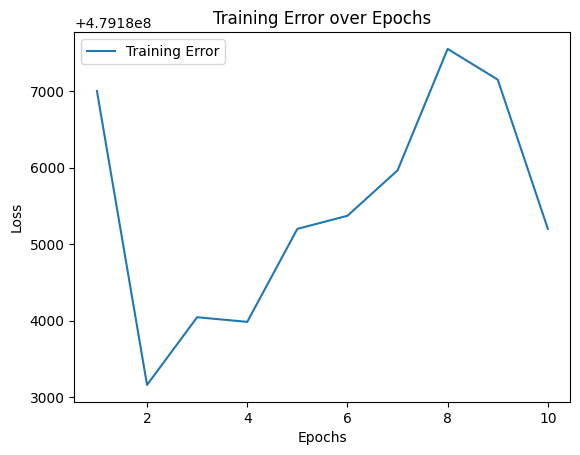

In [11]:
# Plot the error
plt.plot(range(1, epochs+1), errors, label='Training Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error over Epochs')
plt.legend()
plt.show()

In [12]:
# Extract features using the trained RBM
extracted_features = rbm(train_data)
print("Extracted Features:")
print(extracted_features)

Extracted Features:
tf.Tensor(
[[1. 0. 1.]
 [1. 1. 0.]
 [0. 1. 1.]
 ...
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 1.]], shape=(80000, 3), dtype=float32)


In [13]:
rbm.summary()

Model: "rbm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 403 (1.57 KB)
Trainable params: 403 (1.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
